In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/mrsanaullahkhan/2025-dataset/2025_data.csv


In [2]:
# Creating a database and connecting to it using sqlite3.
# ----------------------------------

import sqlite3

csv_path = "/kaggle/input/datasets/mrsanaullahkhan/2025-dataset/2025_data.csv"
db_path = "/kaggle/working/bikeshare.db"
conn= sqlite3.connect(db_path)

try:
    conn = sqlite3.connect(db_path)
    print("Successfully created a database and connected to it using sqlite3")
except sqlite3.Error as e:
    print("Connection failed")
    print("Error:", e)

Successfully created a database and connected to it using sqlite3


In [3]:
# OPTIMIZED Cleaning and Loading (Includes Duration Calculation)
# -------------------------------------------------------------------

# Drop the old table to start fresh (prevents errors)
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS my_table;")
conn.commit()

chunksize = 100_000
dtype_spec = {"ride_id": "string", "rideable_type": "string", "member_casual": "string"}
use_columns = ["ride_id", "rideable_type", "started_at", "ended_at", "member_casual"]

print("Loading data and calculating duration...")

for chunk in pd.read_csv(
    csv_path, # Assumes this is your list of files or the path
    chunksize=chunksize,
    dtype=dtype_spec,
    usecols=use_columns
):
    
    # 1. Remove duplicated header rows
    chunk = chunk[chunk["ride_id"] != "ride_id"].copy()
    
    # 2. Convert datetime
    chunk["started_at"] = pd.to_datetime(chunk["started_at"], errors="coerce")
    chunk["ended_at"] = pd.to_datetime(chunk["ended_at"], errors="coerce")
    
    # 3. Drop rows with missing dates
    chunk = chunk.dropna(subset=["started_at", "ended_at"])
    
    # 4. CALCULATE DURATION HERE (Fast & Efficient)
    # We calculate duration in minutes immediately
    duration = (chunk["ended_at"] - chunk["started_at"]).dt.total_seconds() / 60
    
    # Add it to the chunk as a column
    chunk["ride_duration_minutes"] = duration
    
    # 5. Remove negative/zero duration rides using the new column
    chunk = chunk[chunk["ride_duration_minutes"] > 0]
    
    # 6. Convert datetime back to string for SQLite
    chunk["started_at"] = chunk["started_at"].astype(str)
    chunk["ended_at"] = chunk["ended_at"].astype(str)
    
    # 7. Save to SQL (now includes ride_duration_minutes automatically)
    chunk.to_sql("my_table", conn, if_exists="append", index=False)

print("CSV successfully cleaned, calculated, and loaded.")

# -------------------------------------------------------------------
# Now Create Indexes (Do this AFTER loading)
# -------------------------------------------------------------------
print("Creating indexes...")
cursor.execute("CREATE INDEX IF NOT EXISTS idx_user ON my_table(member_casual)")
cursor.execute("CREATE INDEX IF NOT EXISTS idx_start ON my_table(started_at)")
conn.commit()
print("Done.")

Loading data and calculating duration...
CSV successfully cleaned, calculated, and loaded.
Creating indexes...
Done.


In [4]:
# VIEW FIRST 10 ROWS AND THE STRUCTURE OF THE DATASET.
#---------------------------------------------------

# Configure pandas to display all columns clearly (optional, but helps fit everything on screen)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

query = "SELECT * FROM my_table LIMIT 10;"

df_head = pd.read_sql(query, conn)

# Display the dataframe
print("First 10 rows of cleaned data:")
display(df_head)

# Count total rows in the table
query_count = "SELECT COUNT(*) AS total_rows FROM my_table;"
df_count = pd.read_sql(query_count, conn)

print(f"Total rows in the dataset: {df_count['total_rows'][0]}")

First 10 rows of cleaned data:


,ride_id,rideable_type,started_at,ended_at,member_casual,ride_duration_minutes
0,7569BC890583FCD7,classic_bike,2025-01-21 17:23:54.538,2025-01-21 17:37:52.015,member,13.957950
1,013609308856B7FC,electric_bike,2025-01-11 15:44:06.795,2025-01-11 15:49:11.139,member,5.072400
2,EACACD3CE0607C0D,classic_bike,2025-01-02 15:16:27.730,2025-01-02 15:28:03.230,member,11.591667
3,EAA2485BA64710D3,classic_bike,2025-01-23 08:49:05.814,2025-01-23 08:52:40.047,member,3.570550
4,7F8BE2471C7F746B,electric_bike,2025-01-16 08:38:32.338,2025-01-16 08:41:06.767,member,2.573817
5,0B8DD16A9B77A1C7,electric_bike,2025-01-02 16:09:06.825,2025-01-02 16:10:55.784,member,1.815983
6,65DD88D2EA5AA24A,electric_bike,2025-01-19 01:11:59.684,2025-01-19 01:15:54.187,member,3.908383
7,EAC4EE361C030130,electric_bike,2025-01-24 06:43:28.984,2025-01-24 07:01:38.943,member,18.165983
8,46267A54446162B5,electric_bike,2025-01-06 08:45:24.741,2025-01-06 08:50:20.458,member,4.928617
9,B5D4F9782121EA51,electric_bike,2025-01-01 16:56:36.927,2025-01-01 17:03:26.608,member,6.828017


Total rows in the dataset: 5552965


In [5]:
# Adding ride_duration column and creating indexes for effecient performance PRINTING & VERIFYING THE NEW COLUMN
# ------------------------------


cursor= conn.cursor()
columns = pd.read_sql("PRAGMA table_info(my_table);", conn)

#. if statement in SQLite3 is used to avoid column redunduncy crashes.
if "ride_duration_minutes" not in columns["name"].values:
    cursor.execute(""" 
    ALTER TABLE my_table
    ADD COLUMN ride_duration_minutes REAL
    """)

cursor.execute("""
UPDATE my_table
SET ride_duration_minutes =
    (julianday(ended_at) - julianday(started_at)) * 24 * 60
""")

#. IF NOT EXISTS is used in SQL statement to avoid column redunduncy crashes.
cursor.execute("CREATE INDEX IF NOT EXISTS idx_user ON my_table(member_casual)")
cursor.execute("CREATE INDEX IF NOT EXISTS idx_start ON my_table(started_at)")
cursor.execute("CREATE INDEX IF NOT EXISTS idx_ride_type ON my_table(rideable_type)")
conn.commit()

print("--- Verifying 'ride_duration_minutes' column ---")

# 1. Check the first 5 rows with the new column
query_verify = """
SELECT
    started_at, 
    ended_at, 
    member_casual, 
    ride_duration_minutes 
FROM my_table 
LIMIT 5;
"""

df_verify = pd.read_sql(query_verify, conn)
display(df_verify)

# 2. Check for any anomalies (e.g., negative durations or extremely long rides)
print("\n--- Duration Statistics ---")
query_stats = """
SELECT 
    MIN(ride_duration_minutes) as min_duration,
    MAX(ride_duration_minutes) as max_duration,
    AVG(ride_duration_minutes) as avg_duration
FROM my_table;
"""
df_stats = pd.read_sql(query_stats, conn)
display(df_stats)

--- Verifying 'ride_duration_minutes' column ---


,started_at,ended_at,member_casual,ride_duration_minutes
0,2025-01-21 17:23:54.538,2025-01-21 17:37:52.015,member,13.957950
1,2025-01-11 15:44:06.795,2025-01-11 15:49:11.139,member,5.072400
2,2025-01-02 15:16:27.730,2025-01-02 15:28:03.230,member,11.591667
3,2025-01-23 08:49:05.814,2025-01-23 08:52:40.047,member,3.570550
4,2025-01-16 08:38:32.338,2025-01-16 08:41:06.767,member,2.573817



--- Duration Statistics ---


,min_duration,max_duration,avg_duration
0,0.000766,1574.900184,16.028018


In [6]:
# Selecting required data and perfprming aggregations using SQLite3
# --------------------------------------------------------------------

total_rides = pd.read_sql(
    "SELECT COUNT(*) AS total_rides FROM my_table",
    conn)

df_user = pd.read_sql(""" SELECT member_casual, COUNT(*) AS total_rides FROM my_table
    WHERE member_casual IS NOT NULL
    GROUP BY member_casual
    ORDER BY total_rides DESC
""", conn)

df_duration = pd.read_sql("""
SELECT member_casual, AVG(ride_duration_minutes) AS avg_duration FROM my_table
WHERE ride_duration_minutes IS NOT NULL
GROUP BY member_casual
""", conn)

df_rides= pd.read_sql("""
SELECT rideable_type, COUNT(*) AS total_rides FROM my_table
WHERE rideable_type IS NOT NULL
GROUP BY rideable_type
ORDER BY total_rides DESC
""", conn)

df_peak= pd.read_sql("""
SELECT member_casual, strftime('%H', started_at) AS hour, COUNT(*) AS rides FROM my_table
WHERE started_at IS NOT NULL
GROUP BY member_casual, hour
ORDER BY member_casual, rides DESC
""", conn)



# Convertong 24 hour integer to 12 hour AM/PM format and removing leading zero,
# so 01 PM becomes 1 PM..   Step 1: Get peak hour per member type (Do this first)
# Using the idxmax method as it is cleaner
peak_hour = df_peak.loc[
    df_peak.groupby("member_casual")["rides"].idxmax()
].reset_index(drop=True)

# Step 2: Format the hour column (Do this second)
# We convert to string first to ensure leading zeros (like '05') are handled correctly
peak_hour["hour"] = (
    pd.to_datetime(peak_hour["hour"].astype(str), format="%H")
      .dt.strftime("%I %p")
      .str.lstrip("0")
)
peak_hour


df_day = pd.read_sql(""" SELECT member_casual,CASE strftime('%w', started_at)
        WHEN '0' THEN 'Sunday' WHEN '1' THEN 'Monday' WHEN '2' THEN 'Tuesday'
        WHEN '3' THEN 'Wednesday' WHEN '4' THEN 'Thursday' WHEN '5' THEN 'Friday'
        WHEN '6' THEN 'Saturday'
            END AS weekday, COUNT(*) AS rides FROM my_table
                WHERE started_at IS NOT NULL
                    GROUP BY member_casual, weekday """, conn)

busiest_day = (
    df_day
    .sort_values(["member_casual", "rides"], ascending=[True, False])
    .groupby("member_casual")
    .first()
    .reset_index()
)

print("\n========== DATA SUMMARY ==========")
display(total_rides)

print("\n========== USER TYPE COUNTS ==========")
display(df_user)

print("\n========== AVERAGE DURATION ==========")
display(df_duration)

print("\n========== PEAK HOUR ==========")
display(peak_hour)

print("\n========== BUSIEST DAY ==========")
display(busiest_day)

print("\n========== RIDE TYPE DISTRIBUTION ==========")
display(df_rides)


========== DATA SUMMARY ==========


,total_rides
0,5552965



========== USER TYPE COUNTS ==========


,member_casual,total_rides
0,member,3553477
1,casual,1999488



========== AVERAGE DURATION ==========


,member_casual,avg_duration
0,casual,22.595925
1,member,12.332356



========== PEAK HOUR ==========


,member_casual,hour,rides
0,casual,5 PM,190654
1,member,5 PM,381788



========== BUSIEST DAY ==========


,member_casual,weekday,rides
0,casual,Saturday,414206
1,member,Thursday,576005



========== RIDE TYPE DISTRIBUTION ==========


,rideable_type,total_rides
0,electric_bike,3604936
1,classic_bike,1948029


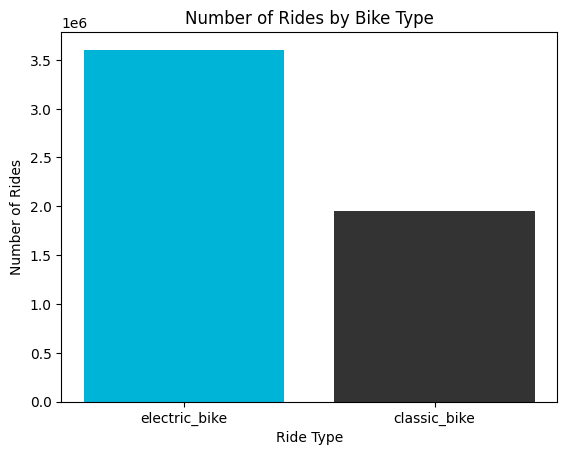

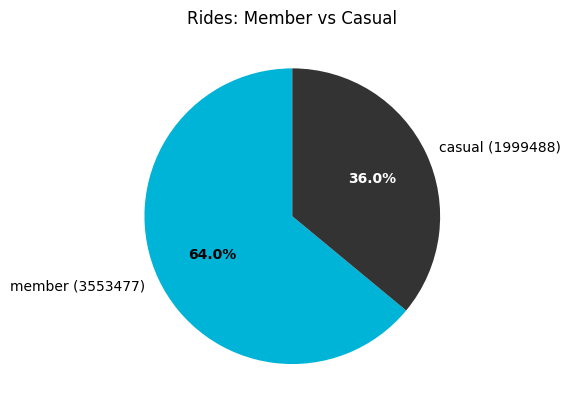

In [7]:
# Visualizations
# ------------------------------
import matplotlib.pyplot as plt

# Brand Colors
divvy_blue = '#00B4D8'   # Light Blue
divvy_dark = '#333333'   # Dark Grey/Black
divvy_light = '#CCCCCC'  # Light Grey for contrast

# --- Plot 1: Number of Rides by Bike Type ---
plt.figure()
# Using the blue as primary, dark as secondary
plt.bar(df_rides['rideable_type'], df_rides['total_rides'], color=[divvy_blue, divvy_dark, divvy_light])
plt.xlabel("Ride Type")
plt.ylabel("Number of Rides")
plt.title("Number of Rides by Bike Type")
plt.show()

# --- Plot 2: Rides Member vs Casual ---
plt.figure()
labels = [
    f"{row['member_casual']} ({row['total_rides']})"
    for _, row in df_user.iterrows()
]

# Define colors: Member = Blue, Casual = Dark
pie_colors = [divvy_blue, divvy_dark]

# Create pie chart and capture the 'autotexts' (the percentage labels)
patches, texts, autotexts = plt.pie(
    df_user['total_rides'], 
    labels=labels, 
    autopct="%1.1f%%", 
    colors=pie_colors, 
    startangle=90
)

# Change text color for visibility:
# autotexts[0] belongs to the first color (Light Blue) -> Use Black text
# autotexts[1] belongs to the second color (Dark Grey) -> Use White text
autotexts[0].set_color('black')
autotexts[1].set_color('white')

# Make the percentage text bold for better readability
for at in autotexts:
    at.set_fontweight('bold')

plt.title("Rides: Member vs Casual")
plt.show()

Processing Aggregations for Time Charts...
Processing Duration Distribution (Chunking for memory efficiency)...
Plotting charts...


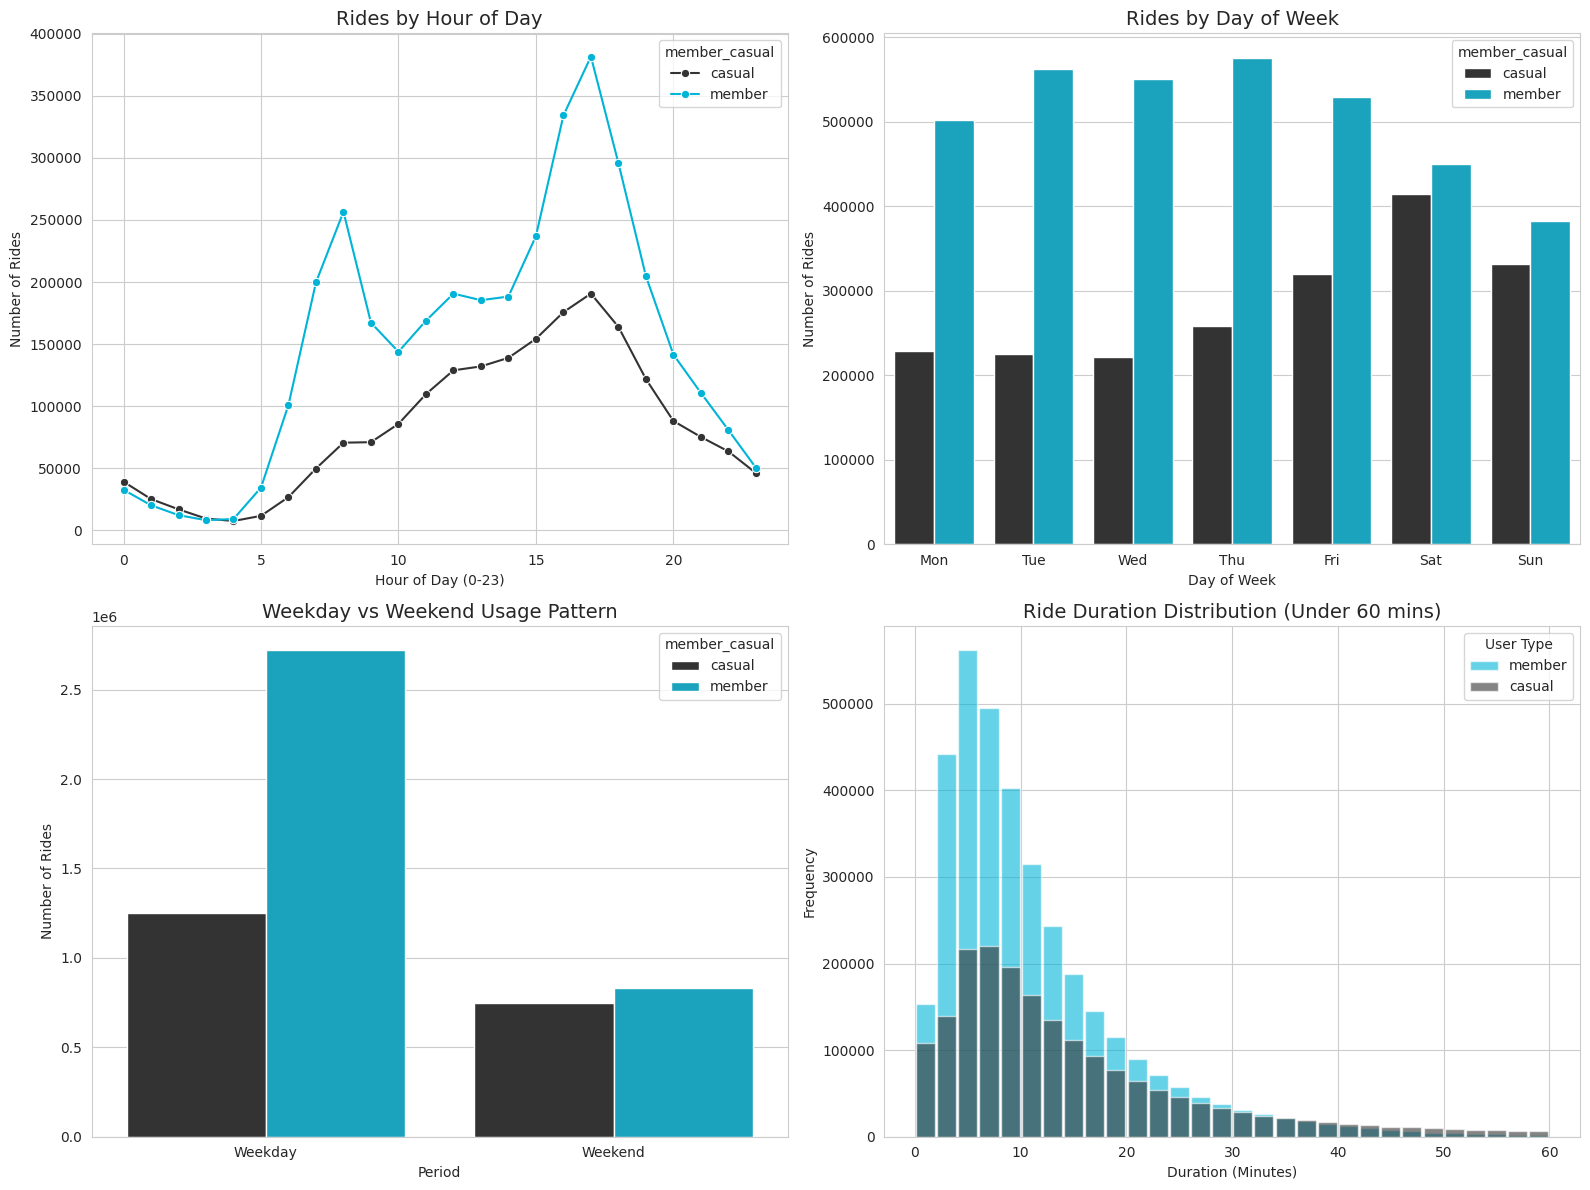

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set visual style
sns.set_style("whitegrid")

# ==========================================
# CHART 1 & 2: Rides by Hour and Day of Week
# ==========================================
print("Processing Aggregations for Time Charts...")

query_time = """
SELECT 
    strftime('%H', started_at) as hour,
    strftime('%w', started_at) as weekday_num,
    member_casual,
    COUNT(*) as ride_count
FROM my_table
GROUP BY hour, weekday_num, member_casual;
"""

df_time = pd.read_sql(query_time, conn)

# Convert types
df_time['hour'] = df_time['hour'].astype(int)
df_time['weekday_num'] = df_time['weekday_num'].astype(int)

# Map weekday numbers to names (0=Sun, 1=Mon...)
day_map = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
df_time['day_name'] = df_time['weekday_num'].map(day_map)

# ==========================================
# CHART 3: Weekday vs Weekend Pattern
# ==========================================
query_pattern = """
SELECT 
    CASE 
        WHEN strftime('%w', started_at) IN ('0', '6') THEN 'Weekend'
        ELSE 'Weekday'
    END as period,
    member_casual,
    COUNT(*) as ride_count
FROM my_table
GROUP BY period, member_casual;
"""
df_pattern = pd.read_sql(query_pattern, conn)

# ==========================================
# CHART 4: Ride Duration Distribution
# ==========================================
print("Processing Duration Distribution (Chunking for memory efficiency)...")

# Bins for histogram: 0 to 60 minutes
bins = np.arange(0, 61, 2)
bin_centers = (bins[:-1] + bins[1:]) / 2

hist_member = np.zeros(len(bin_centers))
hist_casual = np.zeros(len(bin_centers))

# SQL Query for raw duration data
query_duration = """
SELECT 
    member_casual,
    (julianday(ended_at) - julianday(started_at)) * 24 * 60 as duration_minutes
FROM my_table
WHERE ended_at > started_at
"""

# Process in chunks to save RAM
chunk_size = 200_000
for chunk in pd.read_sql(query_duration, conn, chunksize=chunk_size):
    # Filter for valid durations and cap at 60 mins for visualization
    chunk = chunk[(chunk['duration_minutes'] > 0) & (chunk['duration_minutes'] <= 60)]
    
    mem_data = chunk.loc[chunk['member_casual'] == 'member', 'duration_minutes']
    cas_data = chunk.loc[chunk['member_casual'] == 'casual', 'duration_minutes']
    
    # Accumulate histogram counts
    if len(mem_data) > 0:
        hist_member += np.histogram(mem_data, bins=bins)[0]
    if len(cas_data) > 0:
        hist_casual += np.histogram(cas_data, bins=bins)[0]

print("Plotting charts...")



# ==========
# PLOTTING
# ==========

# Updated Palette: Light Blue (Divvy Brand) and Black/Dark Grey for contrast
# 'member' is Light Blue, 'casual' is now Black/Dark Grey
palette = {'member': '#00B4D8', 'casual': '#333333'} 

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Plot 1: Rides by Hour of Day ---
ax1 = axes[0, 0]
sns.lineplot(
    data=df_time.groupby(['hour', 'member_casual'])['ride_count'].sum().reset_index(),
    x='hour', y='ride_count', hue='member_casual', palette=palette, ax=ax1, marker='o'
)
ax1.set_title('Rides by Hour of Day', fontsize=14)
ax1.set_xlabel('Hour of Day (0-23)')
ax1.set_ylabel('Number of Rides')

# --- Plot 2: Rides by Day of Week ---
ax2 = axes[0, 1]
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(
    data=df_time.groupby(['day_name', 'member_casual'])['ride_count'].sum().reset_index(),
    x='day_name', y='ride_count', hue='member_casual', palette=palette, ax=ax2, order=day_order
)
ax2.set_title('Rides by Day of Week', fontsize=14)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Number of Rides')

# --- Plot 3: Weekday vs Weekend ---
ax3 = axes[1, 0]
sns.barplot(
    data=df_pattern, x='period', y='ride_count', hue='member_casual', 
    palette=palette, ax=ax3, order=['Weekday', 'Weekend']
)
ax3.set_title('Weekday vs Weekend Usage Pattern', fontsize=14)
ax3.set_xlabel('Period')
ax3.set_ylabel('Number of Rides')

# --- Plot 4: Duration Distribution ---
ax4 = axes[1, 1]
# The palette dictionary works here too, pulling the new colors automatically
ax4.bar(bin_centers, hist_member, width=1.8, color=palette['member'], label='member', alpha=0.6)
ax4.bar(bin_centers, hist_casual, width=1.8, color=palette['casual'], label='casual', alpha=0.6)
ax4.set_title('Ride Duration Distribution (Under 60 mins)', fontsize=14)
ax4.set_xlabel('Duration (Minutes)')
ax4.set_ylabel('Frequency')
ax4.legend(title='User Type')

plt.tight_layout()
plt.show()